**Цель проекта**:
Выяснить, почему несмотря на высокие вложения в рекламу, приложение Procrastinate Pro+ терпит убытки.

Для определения причин, по которым приложение не окупается, будут использованы следующие шаги:
   - Обработка пропусков и дубликатов
   - Создание профилей пользователей
   - Определение функций для расчета и анализа LTV, CAC и ROI
   - Определение стран, какналов привлечения пользователей и устройств, которые приносят наибольшее количество платящих пользователей
   - Оценка общих расходов на маркетинг
   - Оценка стоимости привлечения одного клиента в разбивке по источникам
   - Оценка окупаемости рекламы в разбивке по странам, устройствам и каналам привлечения пользователей
   - Оценка конверсии в разбивке по странам, устройствам и каналам привлечения пользователей
   - Оценка удержания в разбивке по странам, устройствам и каналам привлечения пользователей
    
**Описание данных**
*Таблица visits (лог сервера с информацией о посещениях сайта):*

    User Id — уникальный идентификатор пользователя

    Device — категория устройства пользователя

    Session start — дата и время начала сессии

    Session End — дата и время окончания сессии

    Channel — идентификатор рекламного источника, из которого пришел пользователь

    Region - страна пользователя

*Таблица orders (информация о заказах):*

    User Id — уникальный id пользователя, который сделал заказ

    Event Dt — дата и время покупки

    Revenue — выручка

*Таблица costs (информация о затратах на маркетинг):*

    Channel — идентификатор рекламного источника

    Dt — дата

    Costs — затраты на этот рекламный источник в этот день

# Шаг 1. Загрузка данных и подготовка их к анализу

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

In [2]:
try:
    #sessions = pd.read_csv('/datasets/visits_info.csv') # данные о визитах
    sessions = pd.read_csv('C:\\Users\\User\\Downloads\\Yandex_projects\\visits_info.csv')
    sessions.to_csv('visits_info.csv', index=False)
    display(sessions.head())
except FileNotFoundError:
    print("Файл не найден")

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47
2,590706206550,United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,326433527971,United States,Android,TipTop,01.05.2019 00:29,01.05.2019 00:54
4,349773784594,United States,Mac,organic,01.05.2019 03:33,01.05.2019 03:57


In [9]:
try:
    #orders = pd.read_csv('/datasets/orders_info.csv') # данные о заказах
    orders = pd.read_csv('C:\\Users\\User\\Downloads\\Yandex_projects\\orders_info.csv')
    orders.to_csv('orders_info.csv', index=False)
    display(orders.head())
except FileNotFoundError:
    print("Файл не найден")

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [10]:
try:
    #costs = pd.read_csv('/datasets/costs_info.csv') # данные о рекламных тратах
    costs = pd.read_csv('C:\\Users\\User\\Downloads\\Yandex_projects\\costs_info.csv')
    costs.to_csv('costs_info.csv', index=False)
    display(costs.head())
except FileNotFoundError:
    print("Файл не найден")

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [11]:
def dataset_info(data):
    """Функция, выводящая информацию о передаваемом датасете и оптимизирующая данные для анализа. Функция принимает датафрейм.
    Функция возвращает датафрейм, в котором посчитано количество пропусков и дубликатов, ячейки с данными строкового типа переведены
    в нижний регистр, названия столбцов переведены в нижний регистр и пробелы в названиях столбцов заменены на нижнее 
    подчеркивание и ячейки, содержащие информацию о времени переведены в формат даты и времени."""
    print('Общая информация')
    data.info() # общая информация о датасете
    print()
    print('Пропуски')
    display(data.isna().sum()) # подсчет количества пропусков в каждом столбце
    data.columns = data.columns.str.lower() # приведение названий столбцов к нижнему регистру
    data.columns = data.columns.str.replace(" ", "_") # замена пробела на нижнее подчеркивание в названиях колонок
    print()
    print('Дубликаты')
    for column in data.columns: # для каждого столбца в переданном датасете
        if column in ['region', 'device', 'channel']:  # если название столбца находится в списке ['region', 'device', 'channel']
            data[column] = data[column].str.lower() # перевести все значения столбца в нижний регистр
        if column == 'session_start' or column == 'session_end': # перевести значения столбцов 'session_start' и 'session_end' в формат даты и времени
            data[column] = pd.to_datetime(data[column], format='%d.%m.%Y %H:%M') 
        if column == 'event_dt': # перевести значения столбцов 'event_dt' в формат даты и времени
            data[column] = pd.to_datetime(data[column], format='%Y-%m-%d %H:%M:%S')
        if column == 'dt': # перевести значения столбцов 'dt' в формат даты и времени
            data[column] = pd.to_datetime(data[column], format='%Y-%m-%d')
    print(data.duplicated().sum()) # подсчет количества дубликатов
    print()
    print("Датасет, подготовленный к анализу")
    data.info()
    return data

In [12]:
print('sessions') 
sessions = dataset_info(sessions) # вызов функции dataset_info к датасету visits

sessions
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB

Пропуски


User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64


Дубликаты
0

Датасет, подготовленный к анализу
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [13]:
print('orders')
orders = dataset_info(orders) # вызов функции dataset_info к датасету orders

orders
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB

Пропуски


User Id     0
Event Dt    0
Revenue     0
dtype: int64


Дубликаты
0

Датасет, подготовленный к анализу
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [14]:
print('costs')
costs = dataset_info(costs) # вызов функции dataset_info к датасету costs

costs
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB

Пропуски


dt         0
Channel    0
costs      0
dtype: int64


Дубликаты
0

Датасет, подготовленный к анализу
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


В данных отсутствуют пропуски и дубликаты. Название столбцов и ячейки с данными типа object были переведены в нижний регистр. В названиях столбцов проблы были заменены нижним подчеркиваением. Столбцы 'session_start', 'session_end', 'event_dt' и 'dt' были переведены в формат даты и времени из формата object.

# Шаг 2. Исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

## Функции для получения профиля пользователей, расчета и анализа LTV, ROI, удержания и конверсии

In [15]:
def get_profiles(sessions, orders, costs):
    """Функция принимает датафреймы с информацией о посещениях пользователей, информацией о покупках и стоимости рекламы.
    Функция возвращает профили пользователей"""

    #параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # определение для когортного анализа даты первого посещения
    # и первого дня месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавление признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # подсчет количества уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

     # объединение трат на рекламу и числа привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

     # создание столбца, занчения которого равны рекламным расходам, разделенным на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавление стоимости привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [16]:

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    """Функция для расчета удержания пользователей. Функция принимает профили пользователей, датафрейм с посещениями пользователей,
    момент анализа, горизонт анализа, параметр, по которому данные будут группироваться и аргумент, показывающий надо ли игнорировать
    горизонт анализа. Функция возвращает данные для расчета удержания, таблицу удержания и таблицу динамики удержания"""

    # добавление столбца payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключение пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        """Функция для группировки таблицы по желаемым признакам. Функция принимает датафрейм, признаки для группировки и 
        горизонт анализа. Функция возращает таблицу, сгруппированную по желаемым признакам, с учетом горизонта анализа"""
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получение таблицы удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получение таблицы динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаются обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


In [17]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    """Функция для расчета конверсии пользователей. Функция принимает профили пользователей, датафрейм с покупками пользователей,
    момент анализа, горизонт анализа, параметр, по которому данные будут группироваться и аргумент, показывающий надо ли игнорировать
    горизонт анализа. Функция возвращает данные для расчета конверсии, таблицу конверсии и таблицу динамики конверсии"""
    # исключение пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определение даты и времени первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавление данных о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчет лайфтайма для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группировка по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        """Функция для группировки таблицы по желаемым признакам. Функция принимает датафрейм, признаки для группировки и 
        горизонт анализа. Функция возращает таблицу, сгруппированную по желаемым признакам, с учетом горизонта анализа"""
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получение таблицы конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии 'cohort' убирается из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получение таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаются обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [18]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    """ Функция для расчета LTV и ROI пользователей. Функция принимает профили пользователей, датафрейм с покупками пользователей,
    момент анализа, горизонт анализа, параметр, по которому данные будут группироваться и аргумент, показывающий надо ли игнорировать
    горизонт анализа. Функция возвращает данные для сырые данные, таблицу LTV, таблицу динамики LTV, таблица ROI,
    таблица динамики ROI."""

    # исключение пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавление данныч о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчет лайфтайма пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группировка по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']


    def group_by_dimensions(df, dims, horizon_days):
        """Функция для группировки таблицы по желаемым признакам. Функция принимает датафрейм, признаки для группировки и 
        горизонт анализа. Функция возращает таблицы LTV и ROI, сгруппированную по желаемым признакам, с учетом горизонта анализа"""
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединение размерыов когорт и таблицы выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # расчет LTV: деление каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключение всех лайфтаймов, превышающих горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавление размеров когорт
        result['cohort_size'] = cohort_sizes

        # сбор датафрейма с данными пользователей и значениями CAC, 
        # добавление параметров из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # расчет среднего CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # расчет ROI: деление LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаление строк с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавление размеров когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавление CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляются размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаются таблицы LTV и ROI
        return result, roi

    # получение таблиц LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убирается 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получение таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [19]:
def filter_data(df, window):
    """Функция для сглаживания фрейма. Функция принимает датафрейм и окно сгляживания. Функция возращает датафрейм,
    где для каждого столбца рассчитано скользящее среднее"""
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [20]:
def plot_retention(retention, retention_history, horizon, window=7):
    """Функция для визуализации удержания. Функция принимает таблицу удержания, таблицу динамики удержания, 
    горизонт анализа и окно сглаживания. Функция возвращает графики удержания платящих пользователей,
    неплатящих пользователей, графики динамики удержания платящих и неплтящих пользователей"""

    # задается размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаются размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляется только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляется второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строятся кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строятся кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    #названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруются данные и строится  график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруются данные и строится график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 


In [21]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    """Функция для визуализации конверсии. Функция принимает таблицу конверсии, таблицу динамики конверсии, 
    горизонт анализа и окно сглаживания. Функция возвращает графики конверсии платящих пользователей,
    неплатящих пользователей, графики динамики конверсии платящих и неплтящих пользователей"""

    # задаётся размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаются размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляются только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [22]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    
    """Функция для визуализации LTV и ROI. Функция принимает таблицу LTV, таблицу динамики LTV, таблицу ROI, таблицу динамики ROI, 
    горизонт анализа и окно сглаживания. Функция возвращает кривую LTV, кривую динамики LTV, кривую динамики САС, кривую ROI и кривую динамики ROI."""

    # задаётся сетка отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаются размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляется только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения записывает в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаются размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляется только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

# Шаг 3. Исследовательский анализ данных

In [23]:
profiles = get_profiles(sessions, orders, costs) # получение профилей пользователй
display(profiles)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,faceboom,mac,united states,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,faceboom,iphone,united states,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iphone,france,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,adnonsense,pc,germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,yrabbit,iphone,united states,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:00,tiptop,iphone,united states,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:00,organic,pc,uk,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:00,tiptop,iphone,united states,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:00,mediatornado,pc,united states,2019-09-28,2019-09-01,False,0.205714


In [24]:
min_date = profiles['dt'].min() # минимальная дата привлечения пользователей
min_date

Timestamp('2019-05-01 00:00:00')

In [25]:
max_date = profiles['dt'].max() # максимальная дата привлечения пользователей
max_date

Timestamp('2019-10-27 00:00:00')

Минимальная и максимальная дата привлечения пользователей совпадают с границами временного промежутка в задании, соответственно, данные полные.

In [26]:
def payer_distr(param):
    """Функция принимает параметр, по которому нужно сгруппировать профили пользователей. Функция возращает таблицу, сгруппированную по регионам, с подсчитанным общим количеством пользователей, 
    количеством платящих пользоватей и процентом платящих пользователей."""
    data_total = profiles.groupby(param).agg({'user_id':'count'}) # создание датафрейма, сгруппированного по заданному параметру, где для каждой группы подсчитано количество пользователей в ней
    data_payer = profiles.query('payer == True').groupby(param).agg({'user_id':'count'}) # датафрейм только с платящими пользователями
    data = data_total.merge(data_payer, on=param, how='left').rename(columns={'user_id_x':'Пользователи', 'user_id_y':'Платящие пользователи'}) # объединение двух предыдущих датафреймов, переименование столбцов с общим количеством пользователей в 'total_clients', с платящими пользователями  - в 'payers'
    data['% платящих'] = round(data['Платящие пользователи']/data['Пользователи'] * 100, 2) # расчет процента платящих пользователей для каждой группы
    data = data.sort_values(by='% платящих', ascending=False) # сортировка таблицы по возрастанию
    return data
def plot_distr(data, text):
    """Функция принимает датафрейм и текст, который нужно вставить в оглавление диаграммы. Функция позвращает круговую диаграмму,
    отражающую процент платящих пользователей в каждой категории, по которой сгруппирован датафрейм"""
    plt.figure(figsize=(12,7)) # размер диаграммы
    colors = sns.color_palette('colorblind') # цвет секторов круговой диаграммы
    plt.pie(data['% платящих'], labels = data.index, colors=colors, autopct='%.2f%%') # построение круговой диаграммы по столбцу с процентом платящих пользователей
    plt.title("Доля платящих пользователей в разбивке по " + text, fontsize=16) # название диаграммы
    

,Пользователи,Платящие пользователи,% платящих
region,,,
united states,100002,6902,6.90
germany,14981,616,4.11
uk,17575,700,3.98
france,17450,663,3.80


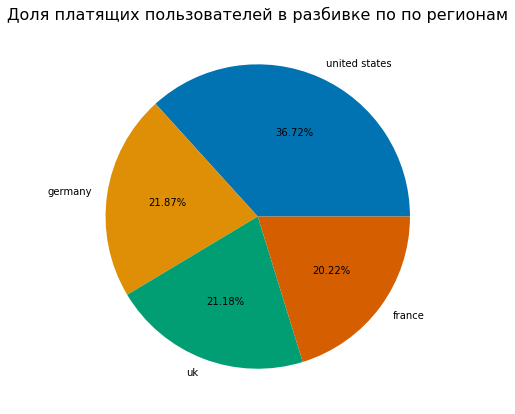

In [27]:
region_distr = payer_distr('region') # вызов функции payer_distr для получения информации о доли платящих пользователей в разбивке по регионам
display(region_distr)
plot_distr(region_distr, 'по регионам')

,Пользователи,Платящие пользователи,% платящих
device,,,
mac,30042,1912,6.36
iphone,54479,3382,6.21
android,35032,2050,5.85
pc,30455,1537,5.05


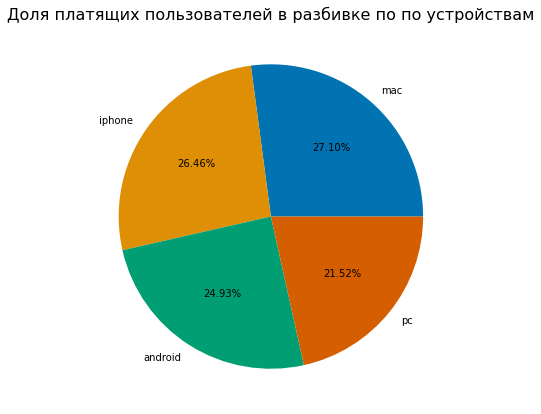

In [28]:
device_distr = payer_distr('device') # вызов функции payer_distr для получения информации о доли платящих пользователей в разбивке по устройствам, с которыхх заходили пользователи
display(device_distr)
plot_distr(device_distr, 'по устройствам')

,Пользователи,Платящие пользователи,% платящих
channel,,,
faceboom,29144,3557,12.20
adnonsense,3880,440,11.34
lambdamediaads,2149,225,10.47
tiptop,19561,1878,9.60
rocketsuperads,4448,352,7.91
wahoonetbanner,8553,453,5.30
yrabbit,4312,165,3.83
mediatornado,4364,156,3.57
leapbob,8553,262,3.06


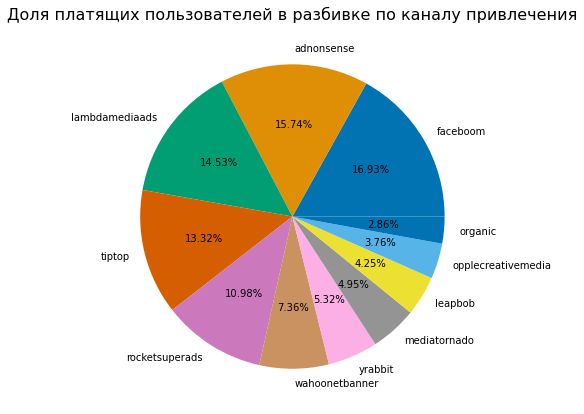

In [29]:
channel_distr = payer_distr('channel') # вызов функции payer_distr для получения информации о доли платящих пользователей в разбивке по каналам привлечения пользователей
display(channel_distr)
plot_distr(channel_distr, 'каналу привлечения')

**Вывод**

Больше всего платящих пользователей в США (6.90% от всех пользователей, заходивших в приложение из США, и 36.72% от всех платящих пользователей), меньше всего - во Франции (3.80% от всех пользователей из Франции и 20.22% от всех платящих пользователей). 

Наибольший процент платящих пользователей встречается среди пользователей, зашедших в прилоджение с Мас (6.36% от пользователей Мас и 27.1% от всех платящих пользователей), наименьший - среди пользователей, зашедших с ПК (5.05% от пользователей ПК и 21.52% от всех платящих пользователей).

Больше всего платящих пользователей были привлечены с помощью каналов faceboom, adnonsense и lambdamediaads (12.20%, 11.34% и 10.47% от всех пользователей привлеченных этими каналами, соответственно, и 16.93%, 15.74% и 14.53% от всех платящих пользователей, соответственно). Меньше всего пользователей привлекают каналы leapbob и opplecreativemedia, также самая низкая доля приходит в приложение самостоятельно (канал organic) (3.06%, 2.71% и 2.06% от пользователей, привлеченных этими каналами, соответственно, и 4.25%, 3.76% и 2.86% от всех платящих пользователей, соответственно).

# Шаг 4. Маркетинг

In [30]:
# общая сумма расходов на маркетинг
costs_total = round(costs['costs'].sum(), 1)
print('Общая сумма расходов на маркетинг:', costs_total)

Общая сумма расходов на маркетинг: 105497.3


In [31]:
# распределение трат на маркетинг по источникам привлечения клиентов
costs_channels = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False).reset_index()
costs_channels

,channel,costs
0,tiptop,54751.30
1,faceboom,32445.60
2,wahoonetbanner,5151.00
3,adnonsense,3911.25
4,opplecreativemedia,2151.25
5,rocketsuperads,1833.00
6,leapbob,1797.60
7,lambdamediaads,1557.60
8,mediatornado,954.48
9,yrabbit,944.22


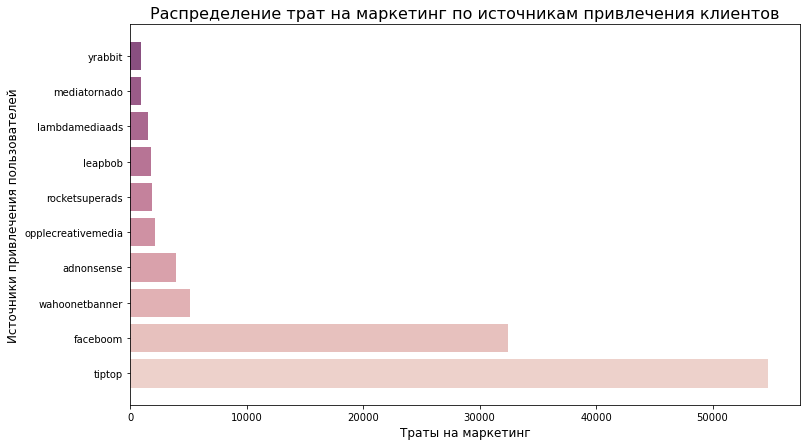

In [32]:
plt.figure(figsize=(12,7)) # размер диаграммы
colors = sns.cubehelix_palette(15) # задание цвета столбцов
plt.barh(costs_channels['channel'],costs_channels['costs'], color=colors) # линейчатый график
plt.xlabel('Траты на маркетинг', fontsize=12) # подпись оси х
plt.ylabel('Источники привлечения пользователей', fontsize=12) # подпись оси у
plt.title('Распределение трат на маркетинг по источникам привлечения клиентов', fontsize=16) # название диаграммы
plt.show()

Самые высокие траты на маркетинг приходятся на каналы tiptop и faceboom. Траты на канал tiptop как минимум в 5 раз выше по сравнению с другими источниками, на faceboom - минимум в 3 раза. 

## Динамика стоимости маркетинговых затрат

Text(0, 0.5, 'Сумма расходов')

<Figure size 864x504 with 0 Axes>

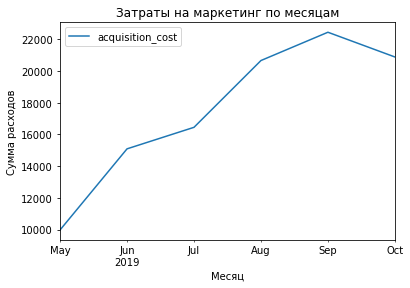

In [33]:
# затраты на маркетинг по общему показателю затрат на маркетинг по месяцам
plt.figure(figsize=(12, 7))
profiles.groupby('month').agg({'acquisition_cost':'sum'}).plot()
plt.title('Затраты на маркетинг по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма расходов')

На графике затрат на маркетинг по месяцам видно, что затраты на маркетинг растут каждый месяц с мая по сентябрь и выросли в общей сумме примерно в 2.2 раза. К концу октября затраты на маркетинг незначительно снизились по сравнению с сентябрем. За весь период с начала мая по конец октября суммарные затраты на маркетинг увеличились в примерно 2 раза.

Text(0, 0.5, 'Сумма расходов')

<Figure size 864x504 with 0 Axes>

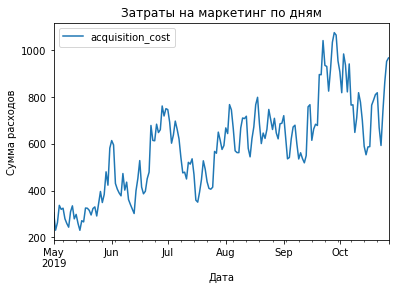

In [34]:
# затраты на маркетинг по общему показателю затрат на маркетинг по дням
plt.figure(figsize=(12, 7))
profiles.groupby('dt').agg({'acquisition_cost':'sum'}).plot()
plt.title('Затраты на маркетинг по дням')
plt.xlabel('Дата')
plt.ylabel('Сумма расходов')

На графике затрат на маркетинг по дням видно, что затраты на маркетинг в день за весь период увеличились в более чем 4 раза. Также на графике видна волнообразная динамике увеличения дневных затрат: затраты на маркетинг, то немного уменьшаются, то возрастают. Однако, в целом, виден значительный рост затрат на конец октября.

Text(0, 0.5, 'Расходы, $')

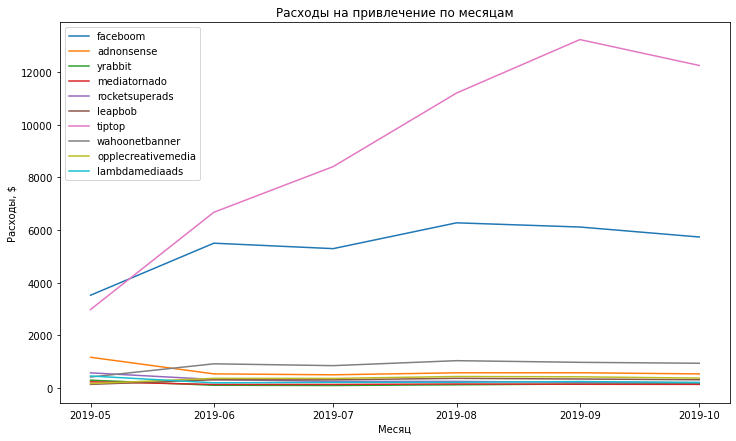

In [35]:
# расходы на привлечение по месяцам
profiles = profiles.query('channel != "organic"') # исключение огранических пользователей
channels = profiles['channel'].unique() # список с уникальными названями каналов
plt.figure(figsize=(12,7)) # размер графика
for i in channels: # для каждого канала
    data = profiles.query(f'channel == "{i}"').pivot_table(index='month', values='acquisition_cost', aggfunc='sum') # для каждого канала формируется сводная таблица, где для каждого месяца считается сумма расходов на реклама по заданному каналу
    plt.plot(data) # построение графика
    plt.legend(channels) # добавление легенды
plt.title('Расходы на привлечение по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Расходы, $')

Text(0, 0.5, 'Расходы, $')

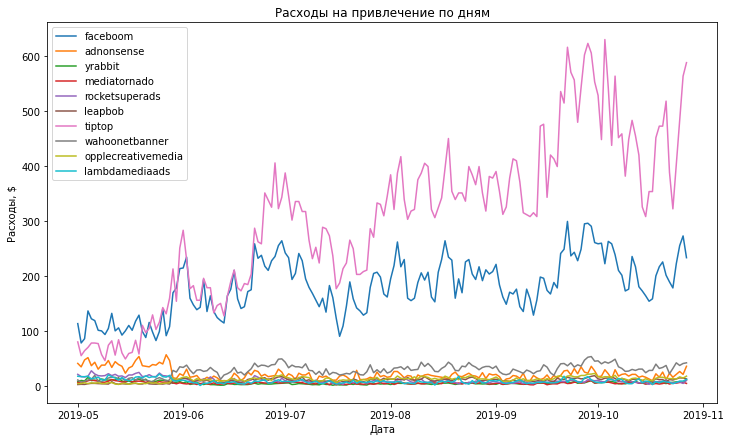

In [36]:
# расходы на привлечение по дням
plt.figure(figsize=(12,7))
for i in channels:
    data = profiles.query(f'channel == "{i}"').pivot_table(index='dt', values='acquisition_cost', aggfunc='sum')
    plt.plot(data)
    plt.legend(channels)
plt.title('Расходы на привлечение по дням')
plt.xlabel('Дата')
plt.ylabel('Расходы, $')

На графиках расходов на привлечения по месяцам и по дням видно, что наибольшие расходы идут на каналы tiptop и faceboom. Особенно сильно (примерно в 4 раза) выросли расходы на tiptop. Расходы на faceboom также подросли, но в примерно 1.5 раза. Несущественно поджросли расходы на wahoonetbanner. Снизились расходы на adnonsense. Расходы по остальным каналам оставались примерно одинаковыми на протяжении всего периода.

In [37]:
# сас для всего проекта
cac_total = round(profiles['acquisition_cost'].sum()/profiles['user_id'].count(), 3)
print('CAC для всего проекта:', cac_total)

CAC для всего проекта: 1.127


In [38]:
# средний сас с разбивкой по источникам
cac = (
    profiles.groupby('channel')
       .agg({'acquisition_cost':'mean'})
       .sort_values(by='acquisition_cost', ascending=False)
       .rename(columns={'acquisition_cost':'cac'})
      )
cac['cac'] = round(cac['cac'], 2)
cac

,cac
channel,
tiptop,2.80
faceboom,1.11
adnonsense,1.01
lambdamediaads,0.72
wahoonetbanner,0.60
rocketsuperads,0.41
opplecreativemedia,0.25
yrabbit,0.22
mediatornado,0.22


Text(0.5, 1.0, 'Средний САС в разбивке по источникам трафика')

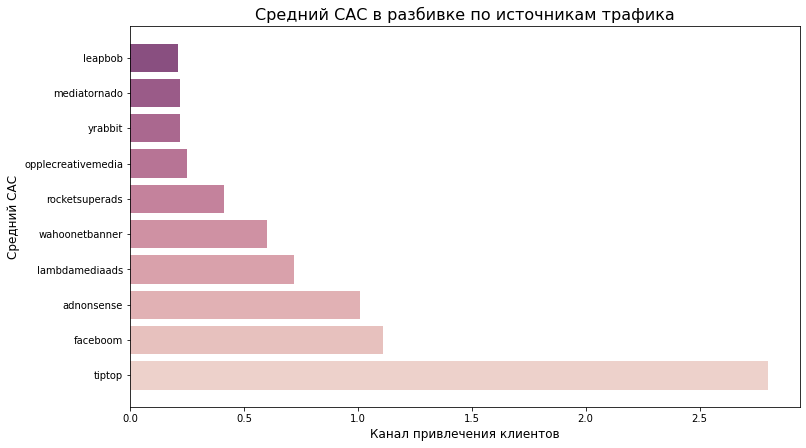

In [39]:
# диаграмма сас для разных каналов привлечения
plt.figure(figsize=(12,7))
colors = sns.cubehelix_palette(15)
plt.barh(cac.index, cac['cac'], color=colors)
plt.xlabel('Канал привлечения клиентов', fontsize=12)
plt.ylabel('Средний САС', fontsize=12)
plt.title('Средний САС в разбивке по источникам трафика', fontsize=16)

Самый высокая стоимость привлечения пользователей у канала tiptop. По сравнению со второым самым дорогим каналом привлечения пользователей, faceboom,  привлечение пользователей через tiptop обходится компании дороже в более чем 2 раза.

# Шаг 5. Оценка окупаемости рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Общая окупаемость рекламы

In [40]:
observation_date = datetime(2019, 11, 1).date() # момент анализа
horizon_days = 14 # горизонт анализа

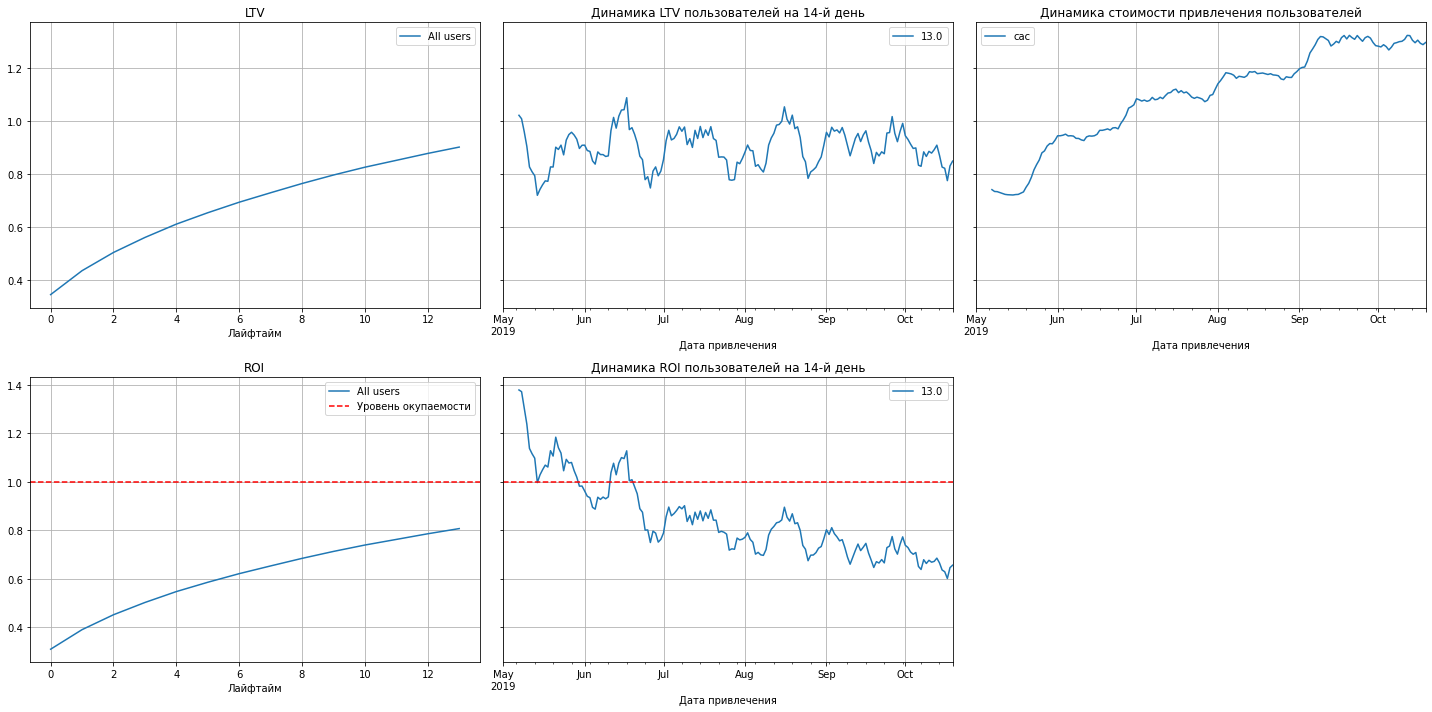

In [41]:
# общие ltv и roi

profiles = profiles.query("channel != 'organic'") # исключение органических пользователей

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# графики динамики ltv, cac и roi
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Динамика LTV пользователей на 14-й день циклична, но с середины июня держится в диапазоне 0.7-0.8.

САС начал увеличивать с середены мая и к концу октября вырос в более чем полтора раза.

График ROI показывает, что реклама не окупается, так как линии LTV и САС не пересекаются.

Динамика ROI пользователей на 14-й день показывает, что окупаемость рекламы начала падать с начала мая. Также с середины июля реклама стабильно не окупается.

### Окупаемость рекламы с разбивкой по странам

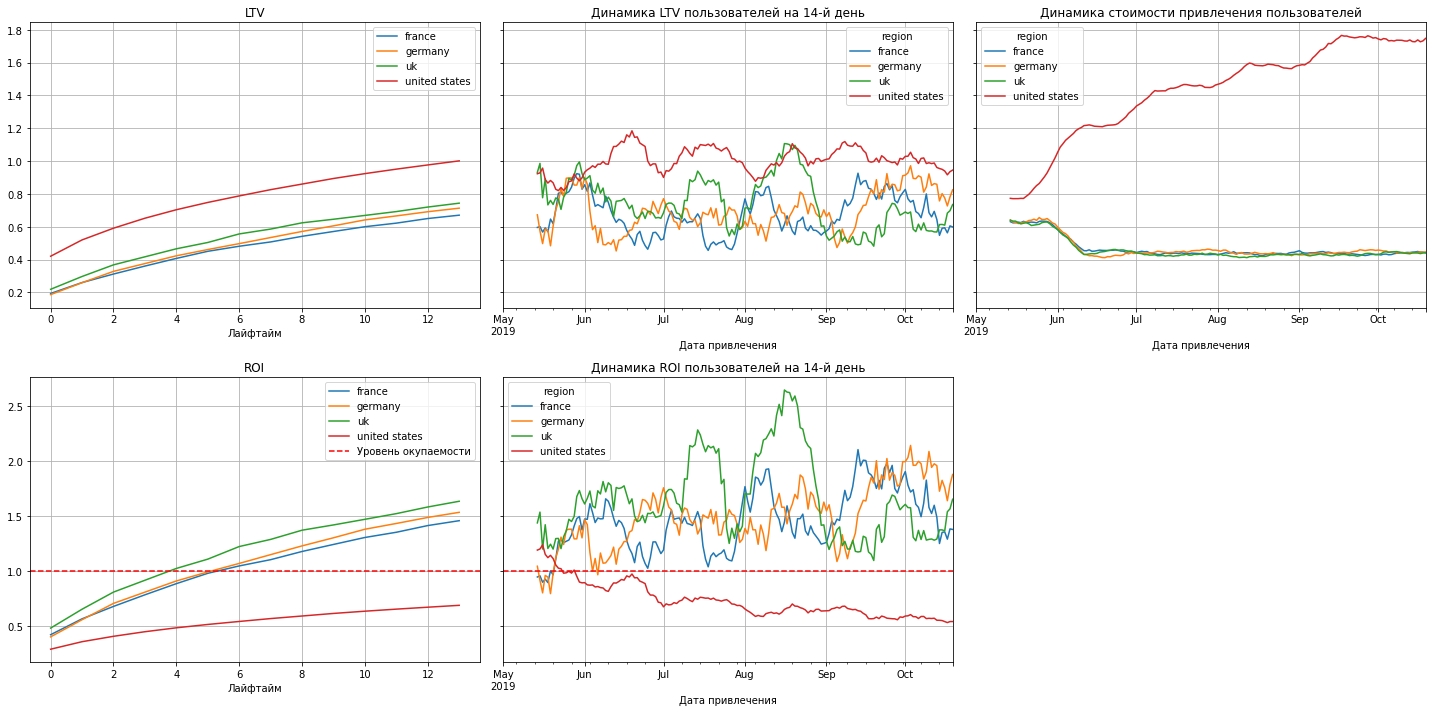

In [42]:
# окупаемость с разбивкой по странам
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

На графике LTV видно, что наибольший доход приносят пользователи из США. Пользователи из Германии, Франции и Великобритании приносят примерно одинаковый доход.

Динамика LTV пользователей на для всех регионов колеблется в характерном для своего региона диапазоне LTV. Наилучшая динамика LTV на 14-й день у пользователей. У пользователей из Великобритании динамика LTV имела существенный пик для пользователей, привлеченных с начала по конец августа.

Судя по графику динамики стоимости привлечения пользователей, стоимость привлечения пользователей в США выросла примерно в 3 раза с наибольшим скачком роста в середине мая - начале июня (САС в этот период вырос более чем в 2 раза). В период с середины мая по начало июня также произошло снижение САС во всех других регионах примернов полтора раза.

График ROI показывает, что пользователи из США - единственные пользователи, которые не окупают рекламу. 

Динамика ROI пользователей на 14-й день показывает, что ROI пользователей из США постоянно уменьшается, начиная с середины мая, также этот график подтверждает тот факт, что пользователи из США стабильно не окупаются с середины июня.

### Окупаемость рекламы с разбивкой по рекламным каналам

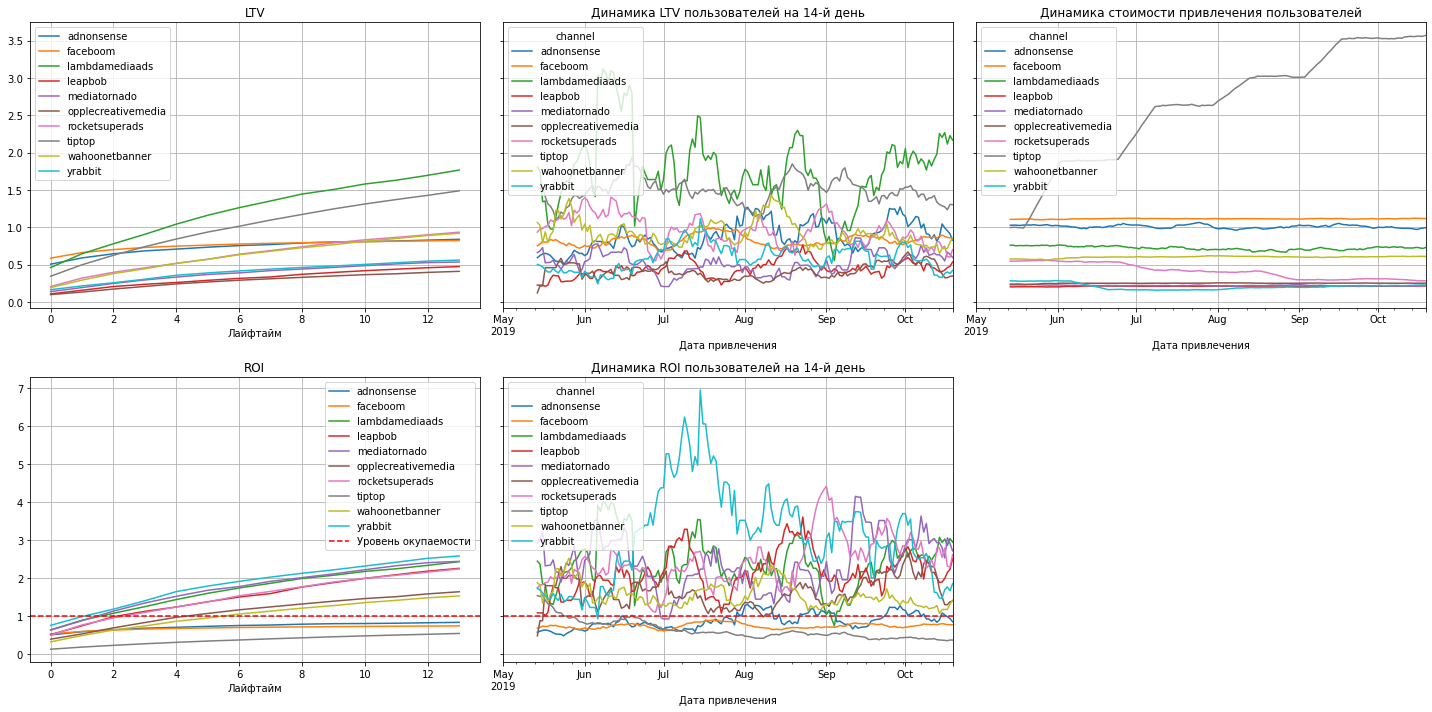

In [43]:
# окупаемость с разбивкой по рекламным каналам
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графику LTV видно, что наибольший доход приносят пользователи, привлеченные с помощью каналов lambdameadiaads и tiptop, наименьший - пользователи привлеченные yrabbit, leapbob, opplecreativemedia и пользователи, пришедшие в приложение самостоятельно (канал organic).

На графике динамики САС видно, что не смотря на то, что tiptop - один из каналов, привлекающих наиболее платящих пользователей, цена на этот канал привлечения выросла приблизительно в 3.5 раза, начиная с середины мая. За период с середины мая по конец октября примерно в два раза упала стоимость привлечения пользователей с канала rocketsuperads и незначительно снизилась стоимость привлечения пользователей с канала yrabbit. В это же время стоимость привлечения пользователей по остальным каналам относительно стабильна. Самыми дешевыми каналами являются каналы opplecreativemediaads, leapbob и yrabbit, самыми дорогими -  tiptop, faceboom и adnonsense.

Графики ROI и динамики ROI пользователей на 14-й день показывают, что пользователи, привлеченные с каналов adnonsense, faceboom и tiptop, не окупаются. В то же время лучше всего окупается канал yrabbit. Также хорошо окупаются каналы mediatornado, lambdamediaads, leapbob, opplecreativemedia и wahoonetbanner. У канала yrabbit заметен значительный рост динамики ROI для пользователей, привлеченных с середины июня (рост ROI более чем в 2 раза). Рост ROI продолжался до середины июля, затем ROI вернулся к своим исходным значениям июня.

### Окупаемость рекламы с разбивкой по устройствам

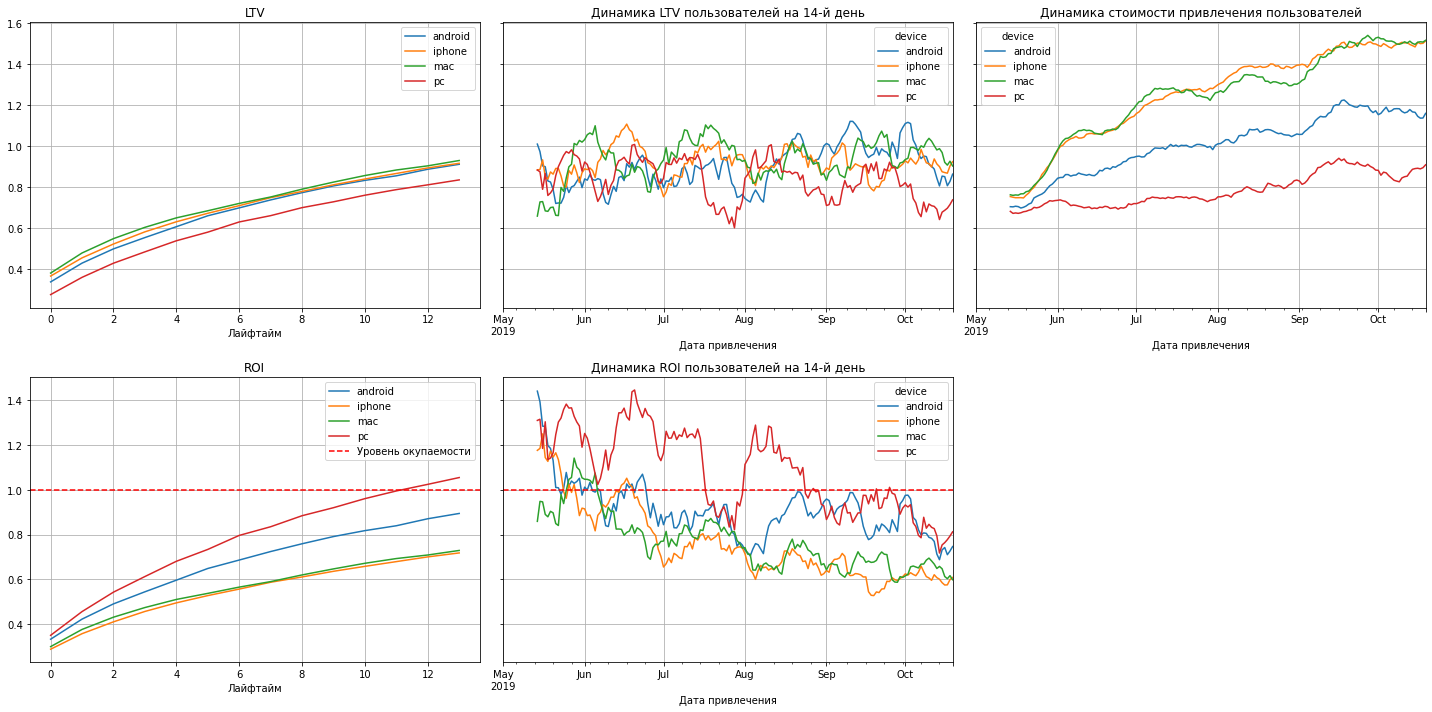

In [44]:
# окупаемость с разбивкой по устройствам
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Судя по графику LTV, наименьший доход приносят пользователи ПК. Пользователи Android, iPhone и Мас приносят приблизительно одинаковое количество денег. 

По графику динамики LTV, видно, что до середины июля пользователи всех устройств имели примерно одинаковый LTV, однако с середины июля LTV пользователей ПК стал несколько ниже по сравнеию с LTV пользователей Android, iPhone и Мас.

Начиная с середины мая стоимость привлечения для пользователей всех устройств увеличивалась. Наименьший рост отмечается для пользователей ПК - для них САС увеличился менее чем в полтора раза; наибольший - для пользователей iPhone и МАС, их САС вырос практически в два раза.

Исходя из графика ROI, окупаются только пользователи ПК.

Судя по динамике ROI, ROI падает для пользователей всех устройств, а когорты, привлеченные с конца августа вообще не окупаются ни с одного устройства. Наименьшее падение ROI к концу октября отмечается для пользователей ПК, наибольшее - для пользователей iPhone.

## Удержание пользователей

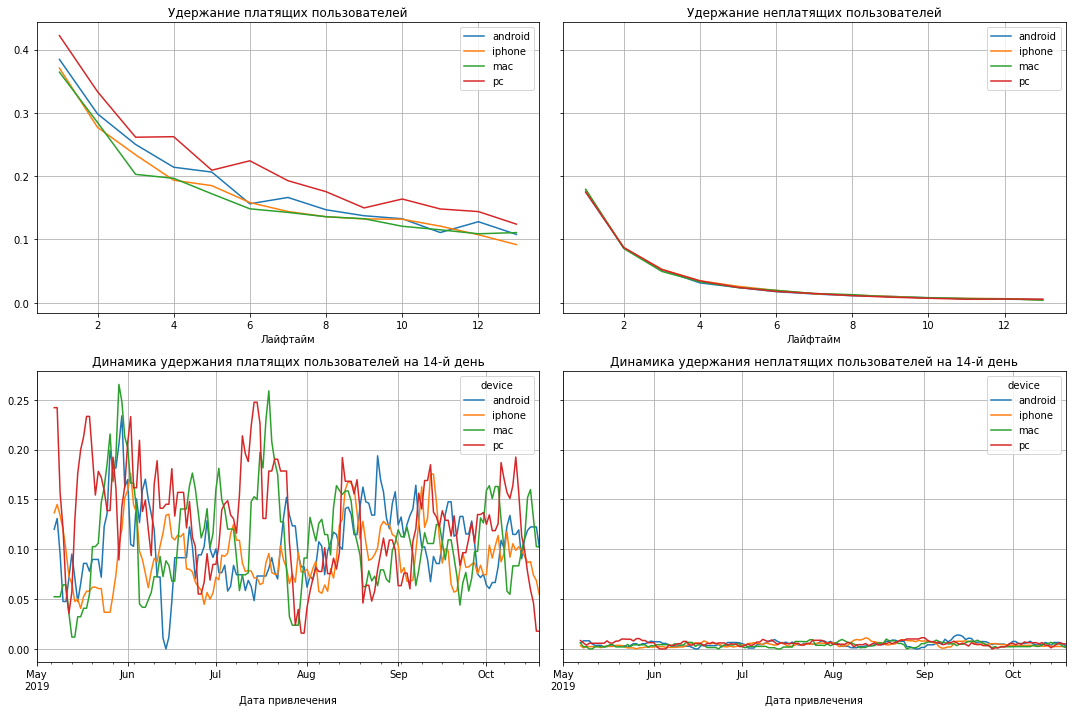

In [45]:
# удержание с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) # графики удержания пользователей в разбивке по устройствам

Удержание пользователей в зависимости от устройства, с которого они заходят в приложение, приблизительно одинаковое, однако у пользователей, зашедших с ПК, оно немного выше остальных. 

Удержание платящих пользователей ожидаемо выше удержания неплатящих.

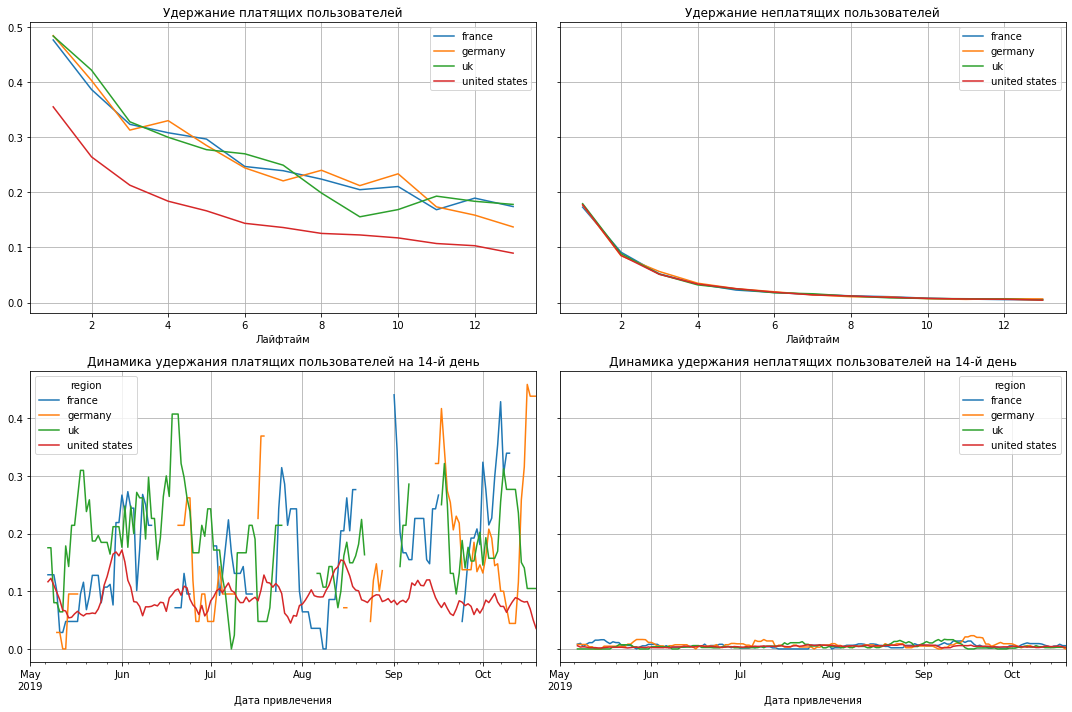

In [46]:
# удержание с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) # графики удержания пользователей в разбивке по странам

Хуже всего удерживаются пользователи из США. Пользователи из Франции, Германии и Великобритании удерживаются примерно одинаково. Неплатящие пользователи удерживаются хуже платящих.

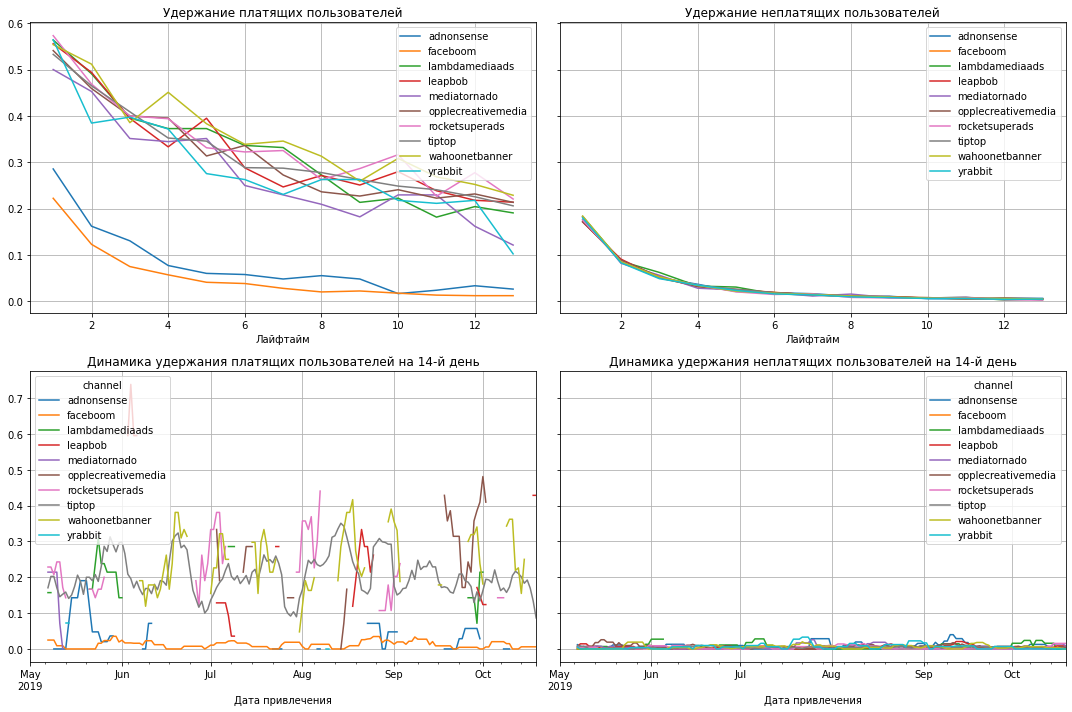

In [47]:
# удержание с разбивкой по рекламным каналам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) # графики удержания пользователей в разбивке по рекланым каналам

Значительно хуже удерживаютcя пользователи, привлеченные с каналов adnonsense и faceboom, по сравнению с остальными пользователями. Удержание пользователей, привлеченных с остальных каналов, приблизительно одинаково. Неплатящие пользователи удерживаются хуже платящих.

## Конверсия пользователей

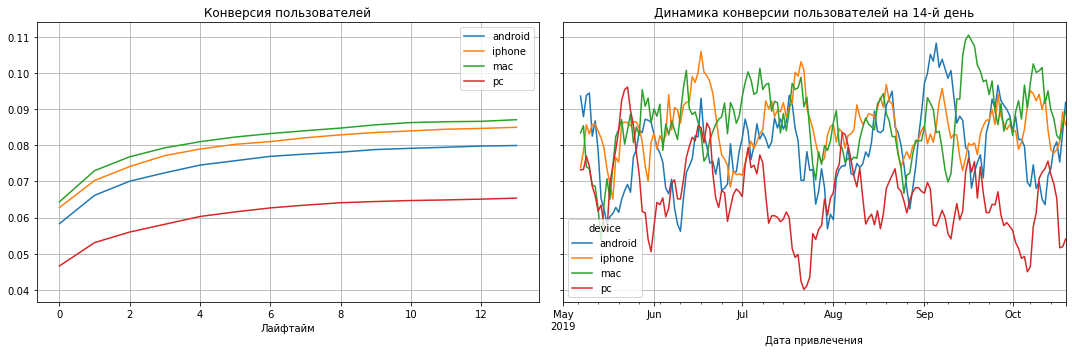

In [48]:
# конверсия с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) # графики конверсии в разбивке по устройствам

Исходя из графиков конверсии и динамики конверсии пользователей на 14-й день в разбивке по устройствам, с которых заходили покупатели, наибольшую конверсию имеют пользователи, заходящие с iPhone, наименьшую - заходящие с ПК.

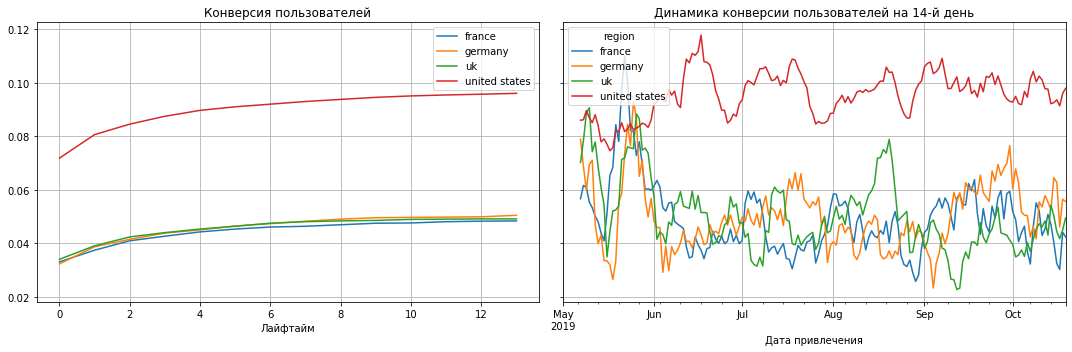

In [49]:
# конверсия с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) # графики конверсии в разбивке по странам

На графиках конверсии и динамики конверсии пользователей на 14-й день в разбивке по странам видно, что наибольшей конверсией обладают пользователи из США, наименьшей - пользователя из Франции, однако конверсии пользователей из Великобритании, Германии и Франции довольно близки друг к другу.

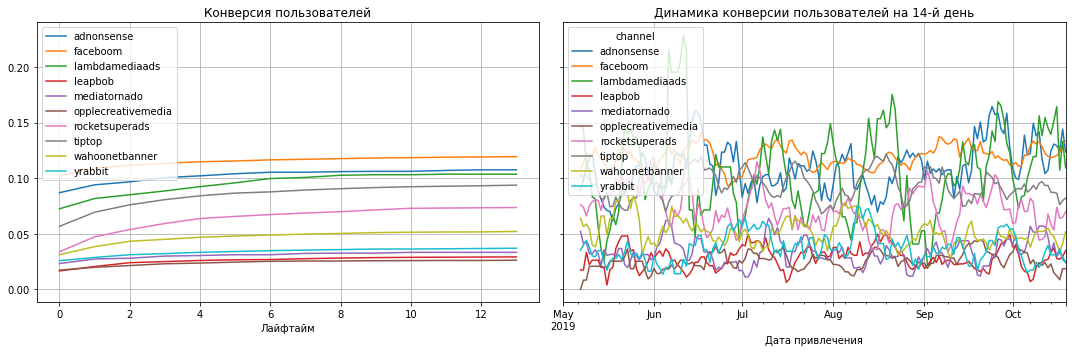

In [50]:
# конверсия с разбивкой по рекламным каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) # графики конверсии в разбивке по рекламным каналам

Из графиков конверсии и динамики конверсии пользователей на 14-й день в разбивке по странам видно, что наилучшую конверсию имеют пользователи, привлеченные каналами faceboom, adnonsense, lambdamediaads и tiptop, наихудшую - leapbob, opplecreativemedia и органические пользователи.

Так как пользовали из США занимают наибольшую долю из всех пользователей приложения и составляют более трети рынка, при этом являясь единствой страной, которая не окупает рекламу, необходимо более подробно рассмотреть причины, по которым реклама в США не окупается.

In [51]:
usa = profiles.query('channel != "organic" and region == "united states"') # пользователи только из США, пришедшие по каналам привлечения пользователей
usa.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,faceboom,mac,united states,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,faceboom,iphone,united states,2019-07-09,2019-07-01,False,1.107237
4,31989216,2019-10-02 00:07:00,yrabbit,iphone,united states,2019-10-02,2019-10-01,False,0.230769
8,58263264,2019-05-11 19:18:00,faceboom,iphone,united states,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:00,mediatornado,iphone,united states,2019-05-11,2019-05-01,False,0.250435


Text(0.5, 1.0, 'Процент привлечения пользователей в США в зависимости от канала')

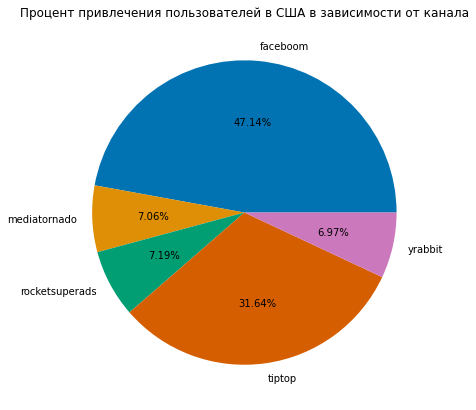

In [52]:
usa_channels = usa.groupby('channel').agg({'user_id':'nunique'}) # количество пользователей, привлеченных каждым каналом в США
colors = sns.color_palette('colorblind')
plt.figure(figsize=(12,7))
plt.pie(usa_channels['user_id'], labels=usa_channels.index, colors=colors, autopct='%.2f%%')
plt.title('Процент привлечения пользователей в США в зависимости от канала')

Основным каналами привлечения пользователей являются Faceboom и Tiptop, привлекая 47.14% и 31.64% пользователей, соответственно. На оставшиеся три канала (Mediatornado, Rocketsuperads и Yrabbit) приходится приблизительно по 7% привлеченных пользователей на каждый канал. 

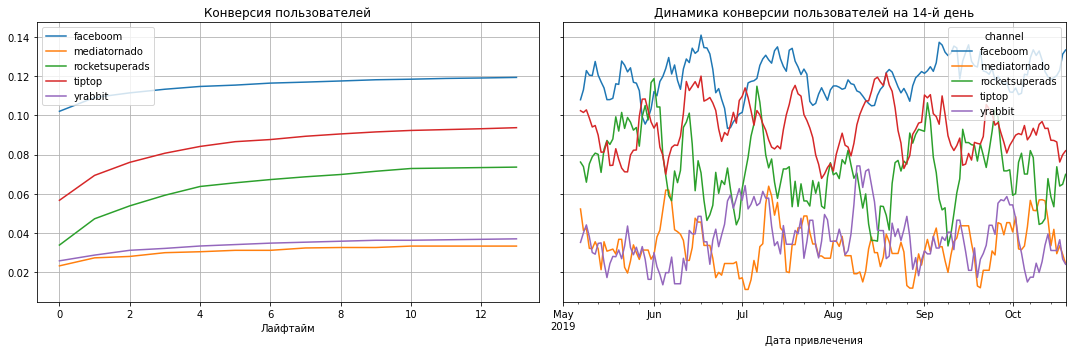

In [53]:
# конверсия и динамика конверсии пользователей на 14-й день для пользователей из США по каналам привлечения
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    usa, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Наилучшую конверсию пользователей имеет канал Faceboom, наихудшую - каналы Yrabbit и Mediatornado.

Судя по графику динамики конверсии пользователей на 14-й, наиболее высокая конверсия у Faceboom, наименее высокая - у Yrabbit и Mediatornado. В целом, у каждого канала динамика конверсии держится примерно в одном и том же диапазоне на протяжении периода с мая по конец октября.

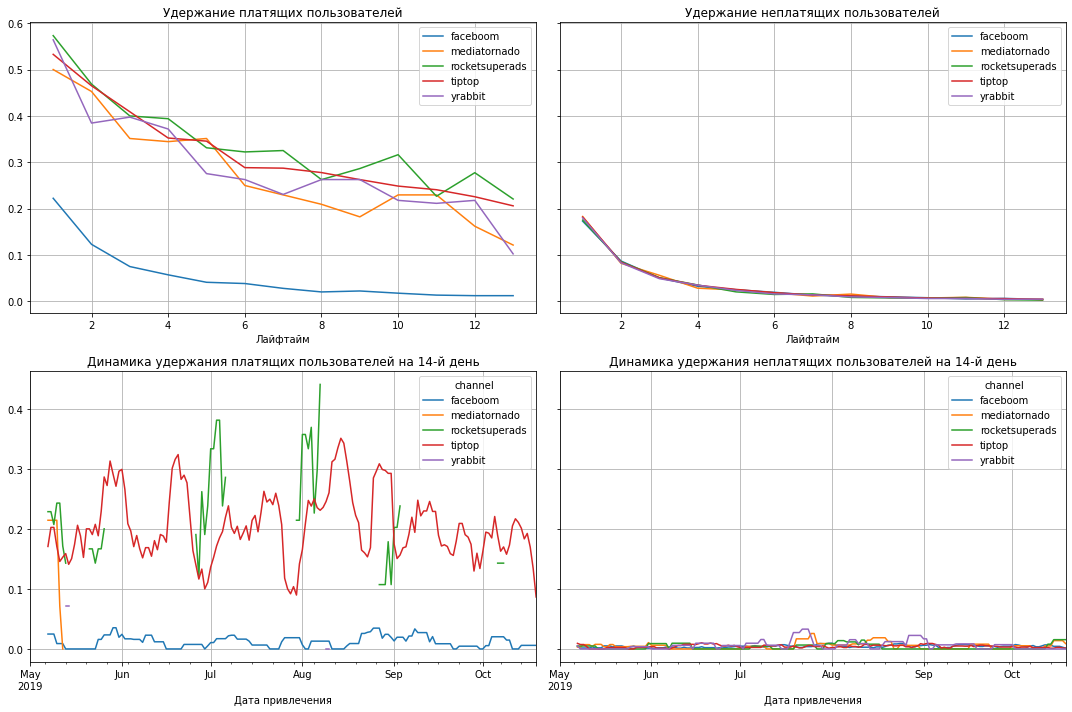

In [54]:
# удержание и динамика удержания пользователей на 14-й день для пользователей из США по каналам привлечения
retention_raw, retention_grouped, retention_history = get_retention(
    usa, sessions, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

На графике удержания платящих пользователей видно, что наихудшее удержание у канала Faceboom (в приблизительно 3 раза ниже, чем у остальных каналов). У каналов Mediatornado, Rocketsuperads, Tiptop и Yrabbit удержание примерно одинаковое.

Исходя из графика динамики удержания платящих пользователей на 14-й день, у Faceboom удержание близко к нулю. У Mediatornado удержание платящих пользователей на 14-й день наиболее стабильное. Каналы Rocketsuperads, Mediatornado и Yrabbit нестабильно удерживают платящих пользователей.

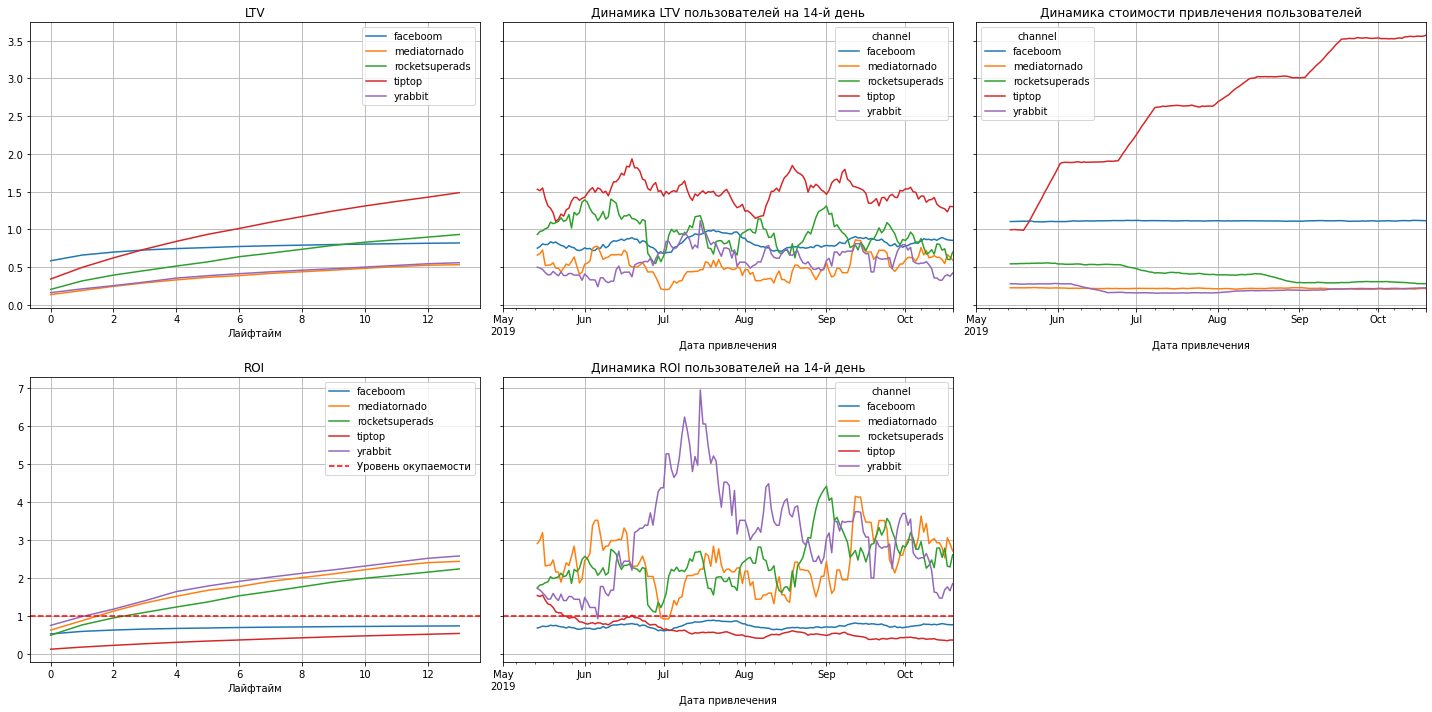

In [55]:
# ltv, cac и roi для пользователей из США по каналам привлечения
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Исходя из графика LTV, наиболее количество денег приносит канал Tiptop, наименьшее - каналы Yrabbit и Mediatornado.

Динамика LTV пользователей на 14-й день на каждого канала довольно стабильна и колеблется в своем диапазоне. Наилучшее LTV на 14-й день у Tiptop, наихудшее - у Mediatornado.

Динамика стоимости привлечения пользователей показывает, что стоимость привлечения пользователей через Tiptop, начиная с середины мая по конец октября, выросла в примерно 3.5 раза. САС канала Faceboom на протяжении периода с мая по конец октября оставался стабильым, как и САС Mediatornado. Стоимость привлечения пользователей снизилась для Rocketsuperads примерно в 2 раза и незначительно снизилась для Yrabbit.

На графике ROI видно, что окупаются Yrabbit, Rocketsuperads и Mediatornado, причем все три канала окупаются на третий день использования приложения, в том время как Faceboom и Tiptop не окупаются вообще.

На графике динамики ROI пользователей на 14-й день видно, что у Yrabbit произошел значительный рост окупаемости для когорт, привлеченных с начала июня до середины июля, когда значения ROI на 14-й день достигло своего максимума и канал Yrabbit имел навысший ROI среди всех каналов в США. После середины июля, ROI Yrabbit начало снижаться, но до середины августа Yrabbit имел наивысший ROI. Также Rocketsuperads и Mediatornado окупались на 14-й день на протяжении всего периода с мая по конец октября. У этих каналов отмечалось некоторое падение ROI с середины июня по середину августа, но затем значения ROI увеличились. Значения ROI ниже уровня окупаемости наблюдались на протяжении всего периода, начиная с середины мая, для Tiptop и на протяжении всего периода для Faceboom.

**Вывод**

Убыточность США объясняется убыточностью каналов привлечения клиентов.

Каналы Tiptop и Faceboom на протяжении периода с середины мая до конца приносили только убытки. В США значительно выросла стоимость привлечения клиентов через канал Tiptop. Также помимо того, что канал Faceboom увляется убыточным, он в 3 раза хуже удерживает пользователей, чем все остальные каналы. 

Канал Tiptop значительно подорожал на протяжении периода с мая по конец октября, но приносит наибольший объем прибыли по сравнению с другими каналами, также он имеет хорошую конверсию и удержание платящих пользователей. В связи с этим необходимо либо пересмотреть оплату канала Tiptop, либо, если этот канал продолжит приносить убытки с новым способом оплаты рекламы, отказаться от этого канала вовсе. 

Стоит отказаться от канала Faceboom. Этот канал приносил исключительно убытки на протяжении на протяжении всего исследуемого периода, к тому же имеет очень низкую конверсию.

Канал Rocketsuperads имеет среднюю конверсию, высокое удержание платящих пользователей, цена привлечения пользователей этого канала снизилась в два раза с мая по конец октября 2019 года, также этот канал на протяжении всего исследуемого периода приносил прибыль. Исходя из этого, имеет смысл увеличить сотрудничество с этим каналом.

Канал Yrabbit имеет хорошее удержание, но низкую конверсию. Также этот канал имел значительный пик ROI на 14-й день использования приложения с конца июня по начало августа. Необходимо выяснить, что вызвало такое сильное увеличение ROI в этот период, и использовать эту стратегию при дальнейшем сотрудничестве с Yrabbit.

Канал Mediatornado имеет хорошее удержание, но самую низкую конверсию. Также этот канал на протяжении всего периода приносил прибыль. Необходимо выяснить, как можно поднять конверсию пользователей, приходящих с этого канала.

**Вывод**

- Реклама в целом не окупается
- На снижение окупаемости рекламы в наибольшей степени влияет убыточность пользователей из США, вызванная ростом стоимости привлечения пользователей с канала tiptop, что сделало этот канал убыточным. Также на отсутсвие окупаемости рекламы в США влияет убыточность канала faceboom. Дополнительно окупаемость рекламы снижает убыточность канала adnonsense, проблемы с конверсией у пользователей ПК и низкая конверсия пользователей из США.
- Реклама может не окупаться по следующим причинам:
    - Значительный рост стоимости привлечения клиентов из США за счет канала tiptop. Не смотря на то, что этот канал привлекает достаточно много платящих пользователей, денег, принесенных пользователями, не хватает на то, чтобы покрыть расходы на рекламу. 
    - Канал faceboom имеет самое низкое удержание пользователей среди всех каналов привлечения и вторую самую высокую стоимость привлечения пользователей, однако он имеет хорошую конверсию. Но конверсия пользователей, привлеченных с этого канала не может покрыть расходы на рекламу, поэтому этот канал является стабильно убыточным. От канала faceboom можно отказаться.
    - Также убыточным является канал adnonsense. Этот канал также имеет очень плохое удержание. От этого канала также можно отказаться.
    - Пользователи из США имеют наилучшую конверсию, но наименьшее удержание. Скорее всего, они также совершают одну покупку и уходят из приложения.
    - Пользователи ПК имеют наилучшее удержание, но наихудшую конверсию. Возможно, у пользователей ПК могут возникать проблемы при оплате покупки в приложении.

# Шаг 6. Финальные выводы

Причины неэффективности привлечения пользователей:
  - Сильный рост стоимости привлечения клиентов через канал tiptop, являющийся причиной убыточности рекламы в США
  - Убыточность рекламных каналов tiptop, faceboom и adnonsense
  - Низкое удержание пользователей из США
  - Низкая конверсия пользователей ПК

Рекомендации для отдела маркетинга для повышения эффективности:

Убыточные каналы привлечения пользователей:
 - В США:
   - Канал tiptop является основной причиной неокупаемости пользователей из США. Стоит выбрать более выгодный способ оплаты рекламы у tiptop. Этот канал привлекает пользователей, которые хорошо удерживаются и конвертируются, но при этом САС для этого канала значительно вырос в период с мая по ноябрь. Если и после этого этот канал привлечения пользователей будет убыточным, то от него будет целесообразным отказаться.
   - Канал faceboom имеет низкое удержание пользователей из США, также этот канал является втором по САС после tiptop. Несмотря на то, что этот канал имеет самую высокую конверсию пользователей из США, деньги, принесенные пользователями не могут покрыть расходов на рекламу. Следовательно, от этого канала можно отказаться.
 - В остальных регионах:
   - У канала adnonsense хорошая конверсия, но худшее удержание платящих пользователей, при этом этот канал также довольно дорогой. Можно также попробовать пересмотреть оплату рекламы для этого канала. Увеличить удержание платящих пользователей, пришедших с этих каналов можно, например, предложив им персонализированные скидки/бонусы.
   
Прибыльные каналы привлечения пользователей:
- В США:
  - Канал rocketsuperads имеет хорошую конверсию и удержание пользователей, также он является прибыльным. Следует увеличить привлечение пользователей с этого канала, особенно в США
  - Каналы mediatornado и yrabbit имеют неплохое удержание, но низкую конверсию. Эти каналы имеют невысокую стоимость привлечения клиентов и окупались на протяжении всего периода с мая по конец октября. Необходимо увеличить привлечение пользователей через эти каналы в США, а также постараться увеличить конверсию пользователей, пришедших с mediatornado и yrabbit.
  - Канал yrabbit имел всплеск ROI в июле. Следует выяснить, что привело к увеличению ROI пользователей, привлеченных yrabbit.
- В остальных регионах:
  - Каналы lambdamediaads, leapbob, opplecreativemedia и wahoonetbanner также являются прибыльными. Все эти каналы имеют приблизительно одинаково хорошее удержание. Однако у пользователей пришедших с opplecreativemedia и wahoonetbanner низкая конверсия, поэтому стоит работать в сторону увеличения конверсии этих пользователей, например, предлагая им индивидуальные бонусы или скидки.
   
Проблемы с удержанием и конверсией:
   - У пользователей ПК самая низкая конверсия. Следует проверить, есть ли у этих пользователей проблемы при оплате покупок. 
   - У пользователей из США наименьшее удержание, несмотря на то, что у этих пользователей наилучшая конверсия и LTV. Можно увеличить удержание, например, сделать в приложении бонусы, или рассылать пользователям push-уведомления, или попробовать изменить/персонализировать интерфейс так, чтобы пользователям из США было удобнее его использовать.
